# PPO

In [19]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback


In [24]:

class RewardLogger(BaseCallback):
    def __init__(self, verbose=1):
        super().__init__(verbose)
        self.episode_rewards = []
        self.current_rewards = 0

    def _on_step(self) -> bool:
        # Collect reward
        self.current_rewards += self.locals["rewards"][0]

        # Detect end of episode
        done = self.locals["dones"][0]
        if done:
            self.episode_rewards.append(self.current_rewards)
            self.current_rewards = 0
        return True

num_envs = 8
total_timesteps = 750_000

# env = DummyVecEnv([make_env for _ in range(num_envs)])
env = make_vec_env("Hopper-v4", n_envs=num_envs)
eval_env = gym.make("Hopper-v4", render_mode="human")

/home/ehk224/RL1/.venv/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment Hopper-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [20]:
def make_env():
    return gym.make("Hopper-v4", render_mode='human')


model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    # batch_size=64,
    # n_epochs=10,
    # learning_rate=3e-4,
    # gamma=0.99,
    # gae_lambda=0.95,
    # clip_range=0.2,
    # ent_coef=0.0,
    # vf_coef=0.5,
    # max_grad_norm=0.5,
    # seed=42,
    tensorboard_log="./ppo_hopper_tensorboard/"
)

reward_logger_ppo = RewardLogger(verbose=1)
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path='./models/', name_prefix='ppo_hopper')
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./best_model/',
    log_path='./eval_logs/',
    eval_freq=5_000,
    deterministic=True,
    render=False
)

model.learn(total_timesteps=total_timesteps,
            callback=[checkpoint_callback, eval_callback, reward_logger_ppo]
            )

model.save("ppo_hopper_final")


Using cuda device
Logging to ./ppo_hopper_tensorboard/PPO_10


/home/ehk224/RL1/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 15.2     |
| time/              |          |
|    fps             | 8096     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.8        |
|    ep_rew_mean          | 27.5        |
| time/                   |             |
|    fps                  | 4121        |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.013880108 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.22       |
|    explained_variance   | 0.0264      |
|    learning_rate        | 0.

/home/ehk224/RL1/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=62.38 +/- 1.16
Episode length: 38.00 +/- 0.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 38          |
|    mean_reward          | 62.4        |
| time/                   |             |
|    total_timesteps      | 40000       |
| train/                  |             |
|    approx_kl            | 0.016539145 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.17       |
|    explained_variance   | 0.384       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.2        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0287     |
|    std                  | 0.968       |
|    value_loss           | 78.8        |
-----------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38

In [21]:


obs, _ = eval_env.reset()
done = False

model_ppo = PPO.load("ppo_hopper_final")
while not done:
    action, _ = model_ppo.predict(obs)
    # out = eval_env.step(action)
    obs, reward, done, terminate, info = eval_env.step(action)
eval_env.close()

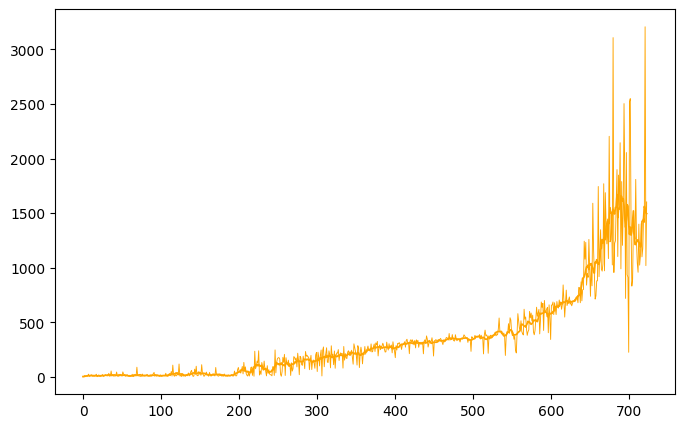

In [22]:
from matplotlib import pyplot as plt
import numpy as np
window_size = 10
rewards = reward_logger_ppo.episode_rewards
colors = ['green', 'purple', 'orange']
plt.figure(figsize=(8,5))

plt.plot(rewards[:-window_size],
             label=PPO,
             linewidth=0.65,
             color=colors[2]
             )
plt.plot(
    np.convolve(rewards,
                np.ones(window_size)/window_size,
                mode='same'
                )[:-window_size],
    linewidth=1.25,
    # label=str(temperature) + '_mean',
    color=colors[2]
    )

# SAC

In [23]:
from stable_baselines3 import SAC

reward_logger_sac = RewardLogger(verbose=1)
model_sac = SAC("MlpPolicy", env, verbose=1, ent_coef='auto')
model_sac.learn(total_timesteps=total_timesteps, callback=reward_logger_sac)
model_sac.save("sac_hopper_final")


Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.2     |
|    ep_rew_mean     | 16.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1642     |
|    time_elapsed    | 0        |
|    total_timesteps | 224      |
| train/             |          |
|    actor_loss      | -3.1     |
|    critic_loss     | 3.79     |
|    ent_coef        | 0.996    |
|    ent_coef_loss   | -0.0212  |
|    learning_rate   | 0.0003   |
|    n_updates       | 15       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.1     |
|    ep_rew_mean     | 21       |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1672     |
|    time_elapsed    | 0        |
|    total_timesteps | 392      |
| train/             |          |
|    actor_loss      | -4.89    |
|    critic_loss     | 1.48   

In [35]:

obs, _ = eval_env.reset()
done = False

model_sac = SAC.load("sac_hopper_final")
while not done:
    action, _ = model_sac.predict(obs)
    # out = eval_env.step(action)
    obs, reward, done, terminate, info = eval_env.step(action)
eval_env.close()

In [1]:
from matplotlib import pyplot as plt
import numpy as np
window_size = 10
rewards = reward_logger_sac.episode_rewards
colors = ['green', 'purple', 'orange']
plt.figure(figsize=(8,5))

plt.plot(rewards[:-window_size],
             label=PPO,
             linewidth=0.65,
             color=colors[1]
             )
plt.plot(
    np.convolve(rewards,
                np.ones(window_size)/window_size,
                mode='same'
                )[:-window_size],
    linewidth=1.25,
    # label=str(temperature) + '_mean',
    color=colors[1]
    )

NameError: name 'reward_logger_sac' is not defined

# TD3

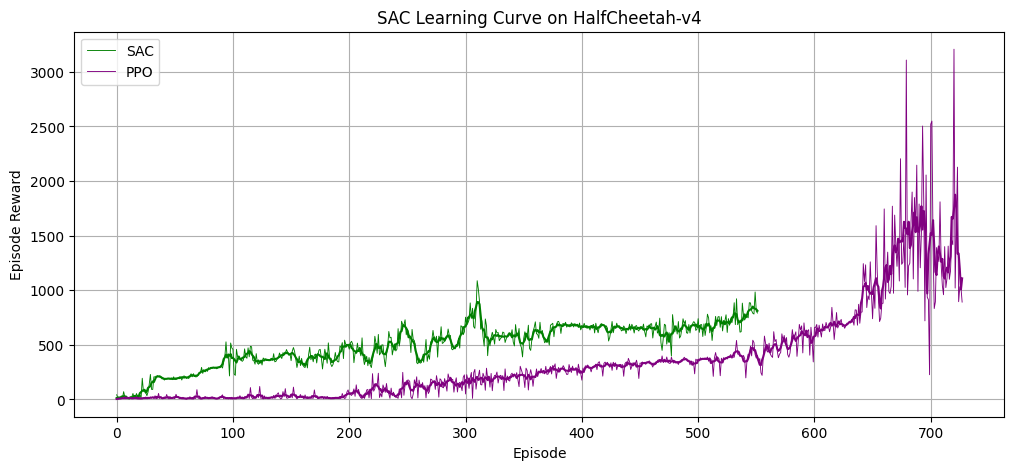

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.3     |
|    ep_rew_mean     | 184      |
| time/              |          |
|    episodes        | 304      |
|    fps             | 425      |
|    time_elapsed    | 36       |
|    total_timesteps | 15562    |
| train/             |          |
|    actor_loss      | -55      |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 15461    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.3     |
|    ep_rew_mean     | 181      |
| time/              |          |
|    episodes        | 308      |
|    fps             | 425      |
|    time_elapsed    | 37       |
|    total_timesteps | 15882    |
| train/             |          |
|    actor_loss      | -54.6    |
|    critic_loss     | 15.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 15781    |
--------------

Eval num_timesteps=20000, episode_reward=142.79 +/- 0.69

Episode length: 82.10 +/- 0.83

---------------------------------
| eval/              |          |
|    mean_ep_length  | 82.1     |
|    mean_reward     | 143      |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -65.4    |
|    critic_loss     | 13.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 19899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.7     |
|    ep_rew_mean     | 169      |
| time/              |          |
|    episodes        | 348      |
|    fps             | 423      |
|    time_elapsed    | 47       |
|    total_timesteps | 20256    |
| train/             |          |
|    actor_loss      | -65.4    |
|    critic_loss     | 25.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 20155    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=30000, episode_reward=441.15 +/- 4.57

Episode length: 228.40 +/- 6.59

---------------------------------
| eval/              |          |
|    mean_ep_length  | 228      |
|    mean_reward     | 441      |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -87.5    |
|    critic_loss     | 30.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 29899    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | 217      |
| time/              |          |
|    episodes        | 436      |
|    fps             | 420      |
|    time_elapsed    | 72       |
|    total_timesteps | 30410    |
| train/             |          |
|    actor_loss      | -90.4    |
|    critic_loss     | 24.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 30309    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | 227      |
| time/              |          |
|    episodes        | 440      |
|    fps             | 420      |
|    time_elapsed    | 74       |
|    total_timesteps | 31399    |
| train/             |          |
|    actor_loss      | -88.9    |
|    critic_loss     | 31.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 31298    |
--------------

Eval num_timesteps=40000, episode_reward=412.48 +/- 8.25

Episode length: 229.10 +/- 7.42

---------------------------------
| eval/              |          |
|    mean_ep_length  | 229      |
|    mean_reward     | 412      |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -93.5    |
|    critic_loss     | 17.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 39899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 136      |
|    ep_rew_mean     | 260      |
| time/              |          |
|    episodes        | 508      |
|    fps             | 418      |
|    time_elapsed    | 96       |
|    total_timesteps | 40538    |
| train/             |          |
|    actor_loss      | -98.1    |
|    critic_loss     | 21.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 40437    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=50000, episode_reward=305.20 +/- 8.95

Episode length: 155.80 +/- 5.51

---------------------------------
| eval/              |          |
|    mean_ep_length  | 156      |
|    mean_reward     | 305      |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -100     |
|    critic_loss     | 29.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 49899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 158      |
|    ep_rew_mean     | 306      |
| time/              |          |
|    episodes        | 564      |
|    fps             | 416      |
|    time_elapsed    | 120      |
|    total_timesteps | 50408    |
| train/             |          |
|    actor_loss      | -103     |
|    critic_loss     | 31.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 50307    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=60000, episode_reward=343.76 +/- 8.83

Episode length: 180.70 +/- 9.20

---------------------------------
| eval/              |          |
|    mean_ep_length  | 181      |
|    mean_reward     | 344      |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -99.2    |
|    critic_loss     | 18.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 59899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | 323      |
| time/              |          |
|    episodes        | 624      |
|    fps             | 416      |
|    time_elapsed    | 145      |
|    total_timesteps | 60646    |
| train/             |          |
|    actor_loss      | -97.5    |
|    critic_loss     | 11.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 60545    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=70000, episode_reward=330.03 +/- 4.08

Episode length: 185.30 +/- 3.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 185      |
|    mean_reward     | 330      |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -105     |
|    critic_loss     | 6.34     |
|    learning_rate   | 0.0003   |
|    n_updates       | 69899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 182      |
|    ep_rew_mean     | 334      |
| time/              |          |
|    episodes        | 676      |
|    fps             | 418      |
|    time_elapsed    | 168      |
|    total_timesteps | 70620    |
| train/             |          |
|    actor_loss      | -103     |
|    critic_loss     | 28.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 70519    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=80000, episode_reward=710.60 +/- 55.35

Episode length: 366.60 +/- 35.43

---------------------------------
| eval/              |          |
|    mean_ep_length  | 367      |
|    mean_reward     | 711      |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -107     |
|    critic_loss     | 7.03     |
|    learning_rate   | 0.0003   |
|    n_updates       | 79899    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 193      |
|    ep_rew_mean     | 358      |
| time/              |          |
|    episodes        | 728      |
|    fps             | 417      |
|    time_elapsed    | 193      |
|    total_timesteps | 80637    |
| train/             |          |
|    actor_loss      | -102     |
|    critic_loss     | 6.8      |
|    learning_rate   | 0.0003   |
|    n_updates       | 80536    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 192      |
|    ep_rew_mean     | 361      |
| time/              |          |
|    episodes        | 732      |
|    fps             | 417      |
|    time_elapsed    | 195      |
|    total_timesteps | 81604    |
| train/             |          |
|    actor_loss      | -102     |
|    critic_loss     | 8.81     |
|    learning_rate   | 0.0003   |
|    n_updates       | 81503    |
--------------

Eval num_timesteps=90000, episode_reward=629.25 +/- 262.56

Episode length: 268.00 +/- 110.70

---------------------------------
| eval/              |          |
|    mean_ep_length  | 268      |
|    mean_reward     | 629      |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -113     |
|    critic_loss     | 5.79     |
|    learning_rate   | 0.0003   |
|    n_updates       | 89899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 214      |
|    ep_rew_mean     | 438      |
| time/              |          |
|    episodes        | 768      |
|    fps             | 417      |
|    time_elapsed    | 216      |
|    total_timesteps | 90436    |
| train/             |          |
|    actor_loss      | -111     |
|    critic_loss     | 12.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 90335    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=100000, episode_reward=519.81 +/- 198.85

Episode length: 222.20 +/- 84.23

---------------------------------
| eval/              |          |
|    mean_ep_length  | 222      |
|    mean_reward     | 520      |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -116     |
|    critic_loss     | 19.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 99899    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 241      |
|    ep_rew_mean     | 531      |
| time/              |          |
|    episodes        | 808      |
|    fps             | 418      |
|    time_elapsed    | 240      |
|    total_timesteps | 100761   |
| train/             |          |
|    actor_loss      | -111     |
|    critic_loss     | 8.62     |
|    learning_rate   | 0.0003   |
|    n_updates       | 100660   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=110000, episode_reward=547.74 +/- 74.34

Episode length: 225.20 +/- 19.44

---------------------------------
| eval/              |          |
|    mean_ep_length  | 225      |
|    mean_reward     | 548      |
| time/              |          |
|    total_timesteps | 110000   |
| train/             |          |
|    actor_loss      | -114     |
|    critic_loss     | 8.56     |
|    learning_rate   | 0.0003   |
|    n_updates       | 109899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 276      |
|    ep_rew_mean     | 626      |
| time/              |          |
|    episodes        | 836      |
|    fps             | 419      |
|    time_elapsed    | 262      |
|    total_timesteps | 110114   |
| train/             |          |
|    actor_loss      | -119     |
|    critic_loss     | 11       |
|    learning_rate   | 0.0003   |
|    n_updates       | 110013   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=120000, episode_reward=1026.32 +/- 96.03

Episode length: 379.10 +/- 29.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 379      |
|    mean_reward     | 1.03e+03 |
| time/              |          |
|    total_timesteps | 120000   |
| train/             |          |
|    actor_loss      | -124     |
|    critic_loss     | 8.26     |
|    learning_rate   | 0.0003   |
|    n_updates       | 119899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 297      |
|    ep_rew_mean     | 721      |
| time/              |          |
|    episodes        | 868      |
|    fps             | 420      |
|    time_elapsed    | 285      |
|    total_timesteps | 120163   |
| train/             |          |
|    actor_loss      | -125     |
|    critic_loss     | 5.65     |
|    learning_rate   | 0.0003   |
|    n_updates       | 120062   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 302      |
|    ep_rew_mean     | 735      |
| time/              |          |
|    episodes        | 872      |
|    fps             | 421      |
|    time_elapsed    | 288      |
|    total_timesteps | 121404   |
| train/             |          |
|    actor_loss      | -126     |
|    critic_loss     | 6.36     |
|    learning_rate   | 0.0003   |
|    n_updates       | 121303   |
--------------

Eval num_timesteps=130000, episode_reward=1055.98 +/- 320.84

Episode length: 378.70 +/- 92.96

---------------------------------
| eval/              |          |
|    mean_ep_length  | 379      |
|    mean_reward     | 1.06e+03 |
| time/              |          |
|    total_timesteps | 130000   |
| train/             |          |
|    actor_loss      | -129     |
|    critic_loss     | 8.04     |
|    learning_rate   | 0.0003   |
|    n_updates       | 129899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 316      |
|    ep_rew_mean     | 813      |
| time/              |          |
|    episodes        | 900      |
|    fps             | 421      |
|    time_elapsed    | 309      |
|    total_timesteps | 130458   |
| train/             |          |
|    actor_loss      | -130     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 130357   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 317      |
|    ep_rew_mean     | 818      |
| time/              |          |
|    episodes        | 904      |
|    fps             | 422      |
|    time_elapsed    | 311      |
|    total_timesteps | 131538   |
| train/             |          |
|    actor_loss      | -134     |
|    critic_loss     | 9.04     |
|    learning_rate   | 0.0003   |
|    n_updates       | 131437   |
--------------

Eval num_timesteps=140000, episode_reward=898.23 +/- 226.59

Episode length: 332.50 +/- 68.09

---------------------------------
| eval/              |          |
|    mean_ep_length  | 332      |
|    mean_reward     | 898      |
| time/              |          |
|    total_timesteps | 140000   |
| train/             |          |
|    actor_loss      | -140     |
|    critic_loss     | 10.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 139899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 309      |
|    ep_rew_mean     | 840      |
| time/              |          |
|    episodes        | 932      |
|    fps             | 422      |
|    time_elapsed    | 331      |
|    total_timesteps | 140023   |
| train/             |          |
|    actor_loss      | -139     |
|    critic_loss     | 12.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 139922   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=150000, episode_reward=1116.20 +/- 45.02

Episode length: 389.70 +/- 13.89

---------------------------------
| eval/              |          |
|    mean_ep_length  | 390      |
|    mean_reward     | 1.12e+03 |
| time/              |          |
|    total_timesteps | 150000   |
| train/             |          |
|    actor_loss      | -145     |
|    critic_loss     | 10.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 149899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 294      |
|    ep_rew_mean     | 785      |
| time/              |          |
|    episodes        | 972      |
|    fps             | 423      |
|    time_elapsed    | 355      |
|    total_timesteps | 150775   |
| train/             |          |
|    actor_loss      | -145     |
|    critic_loss     | 12.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 150674   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 295      |
|    ep_rew_mean     | 791      |
| time/              |          |
|    episodes        | 976      |
|    fps             | 424      |
|    time_elapsed    | 358      |
|    total_timesteps | 152103   |
| train/             |          |
|    actor_loss      | -144     |
|    critic_loss     | 11.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 152002   |
--------------

Eval num_timesteps=160000, episode_reward=1167.90 +/- 188.60

Episode length: 397.80 +/- 49.82

---------------------------------
| eval/              |          |
|    mean_ep_length  | 398      |
|    mean_reward     | 1.17e+03 |
| time/              |          |
|    total_timesteps | 160000   |
| train/             |          |
|    actor_loss      | -160     |
|    critic_loss     | 21.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 159899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 303      |
|    ep_rew_mean     | 832      |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 424      |
|    time_elapsed    | 378      |
|    total_timesteps | 160722   |
| train/             |          |
|    actor_loss      | -151     |
|    critic_loss     | 35.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 160621   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 309      |
|    ep_rew_mean     | 857      |
| time/              |          |
|    episodes        | 1004     |
|    fps             | 424      |
|    time_elapsed    | 382      |
|    total_timesteps | 162437   |
| train/             |          |
|    actor_loss      | -152     |
|    critic_loss     | 72.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 162336   |
--------------

Eval num_timesteps=170000, episode_reward=1429.42 +/- 173.66

Episode length: 477.30 +/- 58.26

---------------------------------
| eval/              |          |
|    mean_ep_length  | 477      |
|    mean_reward     | 1.43e+03 |
| time/              |          |
|    total_timesteps | 170000   |
| train/             |          |
|    actor_loss      | -158     |
|    critic_loss     | 36.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 169899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 320      |
|    ep_rew_mean     | 903      |
| time/              |          |
|    episodes        | 1024     |
|    fps             | 424      |
|    time_elapsed    | 401      |
|    total_timesteps | 170625   |
| train/             |          |
|    actor_loss      | -153     |
|    critic_loss     | 18.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 170524   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 331      |
|    ep_rew_mean     | 936      |
| time/              |          |
|    episodes        | 1028     |
|    fps             | 425      |
|    time_elapsed    | 405      |
|    total_timesteps | 172395   |
| train/             |          |
|    actor_loss      | -160     |
|    critic_loss     | 16.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 172294   |
--------------

Eval num_timesteps=180000, episode_reward=1210.09 +/- 49.98

Episode length: 401.40 +/- 18.11

---------------------------------
| eval/              |          |
|    mean_ep_length  | 401      |
|    mean_reward     | 1.21e+03 |
| time/              |          |
|    total_timesteps | 180000   |
| train/             |          |
|    actor_loss      | -167     |
|    critic_loss     | 52.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 179899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 361      |
|    ep_rew_mean     | 1.05e+03 |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 425      |
|    time_elapsed    | 424      |
|    total_timesteps | 180487   |
| train/             |          |
|    actor_loss      | -159     |
|    critic_loss     | 13.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 180386   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=190000, episode_reward=1346.87 +/- 133.17

Episode length: 435.60 +/- 42.82

---------------------------------
| eval/              |          |
|    mean_ep_length  | 436      |
|    mean_reward     | 1.35e+03 |
| time/              |          |
|    total_timesteps | 190000   |
| train/             |          |
|    actor_loss      | -165     |
|    critic_loss     | 16.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 189899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 393      |
|    ep_rew_mean     | 1.16e+03 |
| time/              |          |
|    episodes        | 1072     |
|    fps             | 425      |
|    time_elapsed    | 446      |
|    total_timesteps | 190120   |
| train/             |          |
|    actor_loss      | -165     |
|    critic_loss     | 14.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 190019   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=200000, episode_reward=838.26 +/- 308.58

Episode length: 297.40 +/- 84.29

---------------------------------
| eval/              |          |
|    mean_ep_length  | 297      |
|    mean_reward     | 838      |
| time/              |          |
|    total_timesteps | 200000   |
| train/             |          |
|    actor_loss      | -173     |
|    critic_loss     | 17.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 199899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 402      |
|    ep_rew_mean     | 1.19e+03 |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 426      |
|    time_elapsed    | 470      |
|    total_timesteps | 200884   |
| train/             |          |
|    actor_loss      | -172     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 200783   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=210000, episode_reward=1028.91 +/- 121.42

Episode length: 329.10 +/- 29.77

---------------------------------
| eval/              |          |
|    mean_ep_length  | 329      |
|    mean_reward     | 1.03e+03 |
| time/              |          |
|    total_timesteps | 210000   |
| train/             |          |
|    actor_loss      | -169     |
|    critic_loss     | 10.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 209899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 391      |
|    ep_rew_mean     | 1.18e+03 |
| time/              |          |
|    episodes        | 1128     |
|    fps             | 427      |
|    time_elapsed    | 495      |
|    total_timesteps | 211482   |
| train/             |          |
|    actor_loss      | -174     |
|    critic_loss     | 28.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 211381   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=220000, episode_reward=1182.86 +/- 117.04

Episode length: 371.50 +/- 28.70

---------------------------------
| eval/              |          |
|    mean_ep_length  | 372      |
|    mean_reward     | 1.18e+03 |
| time/              |          |
|    total_timesteps | 220000   |
| train/             |          |
|    actor_loss      | -178     |
|    critic_loss     | 14.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 219899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 384      |
|    ep_rew_mean     | 1.18e+03 |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 427      |
|    time_elapsed    | 516      |
|    total_timesteps | 220590   |
| train/             |          |
|    actor_loss      | -186     |
|    critic_loss     | 11.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 220489   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=230000, episode_reward=1575.55 +/- 197.87

Episode length: 481.60 +/- 58.84

---------------------------------
| eval/              |          |
|    mean_ep_length  | 482      |
|    mean_reward     | 1.58e+03 |
| time/              |          |
|    total_timesteps | 230000   |
| train/             |          |
|    actor_loss      | -190     |
|    critic_loss     | 54.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 229899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 394      |
|    ep_rew_mean     | 1.24e+03 |
| time/              |          |
|    episodes        | 1176     |
|    fps             | 426      |
|    time_elapsed    | 541      |
|    total_timesteps | 230855   |
| train/             |          |
|    actor_loss      | -184     |
|    critic_loss     | 10.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 230754   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 393      |
|    ep_rew_mean     | 1.24e+03 |
| time/              |          |
|    episodes        | 1180     |
|    fps             | 426      |
|    time_elapsed    | 545      |
|    total_timesteps | 232605   |
| train/             |          |
|    actor_loss      | -188     |
|    critic_loss     | 21       |
|    learning_rate   | 0.0003   |
|    n_updates       | 232504   |
--------------

Eval num_timesteps=240000, episode_reward=2952.97 +/- 401.97

Episode length: 901.90 +/- 129.76

---------------------------------
| eval/              |          |
|    mean_ep_length  | 902      |
|    mean_reward     | 2.95e+03 |
| time/              |          |
|    total_timesteps | 240000   |
| train/             |          |
|    actor_loss      | -197     |
|    critic_loss     | 10.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 239899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 427      |
|    ep_rew_mean     | 1.37e+03 |
| time/              |          |
|    episodes        | 1196     |
|    fps             | 426      |
|    time_elapsed    | 567      |
|    total_timesteps | 241917   |
| train/             |          |
|    actor_loss      | -186     |
|    critic_loss     | 14.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 241816   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 440      |
|    ep_rew_mean     | 1.41e+03 |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 426      |
|    time_elapsed    | 574      |
|    total_timesteps | 244893   |
| train/             |          |
|    actor_loss      | -193     |
|    critic_loss     | 53.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 244792   |
--------------

Eval num_timesteps=250000, episode_reward=2073.36 +/- 587.20

Episode length: 630.60 +/- 184.69

---------------------------------
| eval/              |          |
|    mean_ep_length  | 631      |
|    mean_reward     | 2.07e+03 |
| time/              |          |
|    total_timesteps | 250000   |
| train/             |          |
|    actor_loss      | -201     |
|    critic_loss     | 15.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 249899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 461      |
|    ep_rew_mean     | 1.48e+03 |
| time/              |          |
|    episodes        | 1212     |
|    fps             | 426      |
|    time_elapsed    | 589      |
|    total_timesteps | 251230   |
| train/             |          |
|    actor_loss      | -199     |
|    critic_loss     | 12.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 251129   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=260000, episode_reward=2722.21 +/- 626.15

Episode length: 826.20 +/- 190.52

---------------------------------
| eval/              |          |
|    mean_ep_length  | 826      |
|    mean_reward     | 2.72e+03 |
| time/              |          |
|    total_timesteps | 260000   |
| train/             |          |
|    actor_loss      | -196     |
|    critic_loss     | 8.98     |
|    learning_rate   | 0.0003   |
|    n_updates       | 259899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 489      |
|    ep_rew_mean     | 1.58e+03 |
| time/              |          |
|    episodes        | 1228     |
|    fps             | 425      |
|    time_elapsed    | 611      |
|    total_timesteps | 260386   |
| train/             |          |
|    actor_loss      | -195     |
|    critic_loss     | 13.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 260285   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=270000, episode_reward=2306.71 +/- 458.48

Episode length: 691.80 +/- 133.55

---------------------------------
| eval/              |          |
|    mean_ep_length  | 692      |
|    mean_reward     | 2.31e+03 |
| time/              |          |
|    total_timesteps | 270000   |
| train/             |          |
|    actor_loss      | -198     |
|    critic_loss     | 15.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 269899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 550      |
|    ep_rew_mean     | 1.78e+03 |
| time/              |          |
|    episodes        | 1244     |
|    fps             | 425      |
|    time_elapsed    | 639      |
|    total_timesteps | 272546   |
| train/             |          |
|    actor_loss      | -204     |
|    critic_loss     | 59.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 272445   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=280000, episode_reward=2113.47 +/- 690.40

Episode length: 657.30 +/- 226.14

---------------------------------
| eval/              |          |
|    mean_ep_length  | 657      |
|    mean_reward     | 2.11e+03 |
| time/              |          |
|    total_timesteps | 280000   |
| train/             |          |
|    actor_loss      | -214     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 279899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 585      |
|    ep_rew_mean     | 1.9e+03  |
| time/              |          |
|    episodes        | 1256     |
|    fps             | 425      |
|    time_elapsed    | 659      |
|    total_timesteps | 280854   |
| train/             |          |
|    actor_loss      | -207     |
|    critic_loss     | 56.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 280753   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=290000, episode_reward=2485.11 +/- 735.81

Episode length: 758.50 +/- 224.89

---------------------------------
| eval/              |          |
|    mean_ep_length  | 758      |
|    mean_reward     | 2.49e+03 |
| time/              |          |
|    total_timesteps | 290000   |
| train/             |          |
|    actor_loss      | -209     |
|    critic_loss     | 8.79     |
|    learning_rate   | 0.0003   |
|    n_updates       | 289899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 611      |
|    ep_rew_mean     | 1.99e+03 |
| time/              |          |
|    episodes        | 1272     |
|    fps             | 425      |
|    time_elapsed    | 681      |
|    total_timesteps | 290054   |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 14       |
|    learning_rate   | 0.0003   |
|    n_updates       | 289953   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=300000, episode_reward=2889.86 +/- 701.73

Episode length: 880.90 +/- 210.96

---------------------------------
| eval/              |          |
|    mean_ep_length  | 881      |
|    mean_reward     | 2.89e+03 |
| time/              |          |
|    total_timesteps | 300000   |
| train/             |          |
|    actor_loss      | -214     |
|    critic_loss     | 16.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 299899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 632      |
|    ep_rew_mean     | 2.06e+03 |
| time/              |          |
|    episodes        | 1288     |
|    fps             | 425      |
|    time_elapsed    | 707      |
|    total_timesteps | 300791   |
| train/             |          |
|    actor_loss      | -215     |
|    critic_loss     | 10.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 300690   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=310000, episode_reward=3206.08 +/- 44.20

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.21e+03 |
| time/              |          |
|    total_timesteps | 310000   |
| train/             |          |
|    actor_loss      | -224     |
|    critic_loss     | 18.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 309899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 666      |
|    ep_rew_mean     | 2.18e+03 |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 425      |
|    time_elapsed    | 737      |
|    total_timesteps | 313680   |
| train/             |          |
|    actor_loss      | -216     |
|    critic_loss     | 13.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 313579   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 675      |
|    ep_rew_mean     | 2.2e+03  |
| time/              |          |
|    episodes        | 1308     |
|    fps             | 425      |
|    time_elapsed    | 745      |
|    total_timesteps | 317181   |
| train/             |          |
|    actor_loss      | -226     |
|    critic_loss     | 16       |
|    learning_rate   | 0.0003   |
|    n_updates       | 317080   |
--------------

Eval num_timesteps=320000, episode_reward=3184.59 +/- 28.20

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.18e+03 |
| time/              |          |
|    total_timesteps | 320000   |
| train/             |          |
|    actor_loss      | -228     |
|    critic_loss     | 15.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 319899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 690      |
|    ep_rew_mean     | 2.25e+03 |
| time/              |          |
|    episodes        | 1312     |
|    fps             | 424      |
|    time_elapsed    | 754      |
|    total_timesteps | 320230   |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 17.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 320129   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=330000, episode_reward=3254.15 +/- 3.68

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.25e+03 |
| time/              |          |
|    total_timesteps | 330000   |
| train/             |          |
|    actor_loss      | -229     |
|    critic_loss     | 10.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 329899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 730      |
|    ep_rew_mean     | 2.38e+03 |
| time/              |          |
|    episodes        | 1324     |
|    fps             | 423      |
|    time_elapsed    | 782      |
|    total_timesteps | 331569   |
| train/             |          |
|    actor_loss      | -232     |
|    critic_loss     | 9.2      |
|    learning_rate   | 0.0003   |
|    n_updates       | 331468   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 752      |
|    ep_rew_mean     | 2.45e+03 |
| time/              |          |
|    episodes        | 1328     |
|    fps             | 424      |
|    time_elapsed    | 791      |
|    total_timesteps | 335569   |
| train/             |          |
|    actor_loss      | -226     |
|    critic_loss     | 14.7     |
|    learning_rate   | 0.0003   |
|    n_updates       | 335468   |
--------------

Eval num_timesteps=340000, episode_reward=3199.99 +/- 6.27

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.2e+03  |
| time/              |          |
|    total_timesteps | 340000   |
| train/             |          |
|    actor_loss      | -237     |
|    critic_loss     | 16.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 339899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 770      |
|    ep_rew_mean     | 2.51e+03 |
| time/              |          |
|    episodes        | 1336     |
|    fps             | 422      |
|    time_elapsed    | 812      |
|    total_timesteps | 343569   |
| train/             |          |
|    actor_loss      | -242     |
|    critic_loss     | 15.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 343468   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=350000, episode_reward=3226.30 +/- 9.75

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.23e+03 |
| time/              |          |
|    total_timesteps | 350000   |
| train/             |          |
|    actor_loss      | -240     |
|    critic_loss     | 8.04     |
|    learning_rate   | 0.0003   |
|    n_updates       | 349899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 790      |
|    ep_rew_mean     | 2.57e+03 |
| time/              |          |
|    episodes        | 1344     |
|    fps             | 421      |
|    time_elapsed    | 833      |
|    total_timesteps | 351569   |
| train/             |          |
|    actor_loss      | -246     |
|    critic_loss     | 10.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 351468   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=360000, episode_reward=3257.21 +/- 5.76

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 360000   |
| train/             |          |
|    actor_loss      | -238     |
|    critic_loss     | 13.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 359899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 807      |
|    ep_rew_mean     | 2.61e+03 |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 421      |
|    time_elapsed    | 858      |
|    total_timesteps | 361507   |
| train/             |          |
|    actor_loss      | -246     |
|    critic_loss     | 11.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 361406   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 811      |
|    ep_rew_mean     | 2.63e+03 |
| time/              |          |
|    episodes        | 1360     |
|    fps             | 421      |
|    time_elapsed    | 864      |
|    total_timesteps | 364151   |
| train/             |          |
|    actor_loss      | -249     |
|    critic_loss     | 9.94     |
|    learning_rate   | 0.0003   |
|    n_updates       | 364050   |
--------------

Eval num_timesteps=370000, episode_reward=1645.89 +/- 799.37

Episode length: 501.70 +/- 250.75

---------------------------------
| eval/              |          |
|    mean_ep_length  | 502      |
|    mean_reward     | 1.65e+03 |
| time/              |          |
|    total_timesteps | 370000   |
| train/             |          |
|    actor_loss      | -256     |
|    critic_loss     | 9.71     |
|    learning_rate   | 0.0003   |
|    n_updates       | 369899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 836      |
|    ep_rew_mean     | 2.71e+03 |
| time/              |          |
|    episodes        | 1368     |
|    fps             | 420      |
|    time_elapsed    | 883      |
|    total_timesteps | 371548   |
| train/             |          |
|    actor_loss      | -251     |
|    critic_loss     | 6.66     |
|    learning_rate   | 0.0003   |
|    n_updates       | 371447   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=380000, episode_reward=3267.10 +/- 4.55

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.27e+03 |
| time/              |          |
|    total_timesteps | 380000   |
| train/             |          |
|    actor_loss      | -260     |
|    critic_loss     | 8.78     |
|    learning_rate   | 0.0003   |
|    n_updates       | 379899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 874      |
|    ep_rew_mean     | 2.83e+03 |
| time/              |          |
|    episodes        | 1380     |
|    fps             | 419      |
|    time_elapsed    | 912      |
|    total_timesteps | 382922   |
| train/             |          |
|    actor_loss      | -257     |
|    critic_loss     | 16.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 382821   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 889      |
|    ep_rew_mean     | 2.88e+03 |
| time/              |          |
|    episodes        | 1384     |
|    fps             | 419      |
|    time_elapsed    | 921      |
|    total_timesteps | 386922   |
| train/             |          |
|    actor_loss      | -258     |
|    critic_loss     | 10.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 386821   |
--------------

Eval num_timesteps=390000, episode_reward=3257.08 +/- 2.89

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 390000   |
| train/             |          |
|    actor_loss      | -265     |
|    critic_loss     | 7.1      |
|    learning_rate   | 0.0003   |
|    n_updates       | 389899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 901      |
|    ep_rew_mean     | 2.91e+03 |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 419      |
|    time_elapsed    | 932      |
|    total_timesteps | 390922   |
| train/             |          |
|    actor_loss      | -268     |
|    critic_loss     | 9.48     |
|    learning_rate   | 0.0003   |
|    n_updates       | 390821   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=400000, episode_reward=3210.24 +/- 3.38

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.21e+03 |
| time/              |          |
|    total_timesteps | 400000   |
| train/             |          |
|    actor_loss      | -262     |
|    critic_loss     | 9.4      |
|    learning_rate   | 0.0003   |
|    n_updates       | 399899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 929      |
|    ep_rew_mean     | 3e+03    |
| time/              |          |
|    episodes        | 1400     |
|    fps             | 418      |
|    time_elapsed    | 962      |
|    total_timesteps | 402922   |
| train/             |          |
|    actor_loss      | -266     |
|    critic_loss     | 13.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 402821   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=410000, episode_reward=3222.88 +/- 3.03

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.22e+03 |
| time/              |          |
|    total_timesteps | 410000   |
| train/             |          |
|    actor_loss      | -276     |
|    critic_loss     | 7.76     |
|    learning_rate   | 0.0003   |
|    n_updates       | 409899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 937      |
|    ep_rew_mean     | 3.02e+03 |
| time/              |          |
|    episodes        | 1408     |
|    fps             | 418      |
|    time_elapsed    | 982      |
|    total_timesteps | 410922   |
| train/             |          |
|    actor_loss      | -279     |
|    critic_loss     | 6.64     |
|    learning_rate   | 0.0003   |
|    n_updates       | 410821   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=420000, episode_reward=3269.07 +/- 7.10

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.27e+03 |
| time/              |          |
|    total_timesteps | 420000   |
| train/             |          |
|    actor_loss      | -279     |
|    critic_loss     | 7.53     |
|    learning_rate   | 0.0003   |
|    n_updates       | 419899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1420     |
|    fps             | 417      |
|    time_elapsed    | 1011     |
|    total_timesteps | 422198   |
| train/             |          |
|    actor_loss      | -278     |
|    critic_loss     | 7.05     |
|    learning_rate   | 0.0003   |
|    n_updates       | 422097   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1424     |
|    fps             | 417      |
|    time_elapsed    | 1020     |
|    total_timesteps | 426198   |
| train/             |          |
|    actor_loss      | -274     |
|    critic_loss     | 8.13     |
|    learning_rate   | 0.0003   |
|    n_updates       | 426097   |
--------------

Eval num_timesteps=430000, episode_reward=3186.48 +/- 5.53

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.19e+03 |
| time/              |          |
|    total_timesteps | 430000   |
| train/             |          |
|    actor_loss      | -278     |
|    critic_loss     | 5.75     |
|    learning_rate   | 0.0003   |
|    n_updates       | 429899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1428     |
|    fps             | 416      |
|    time_elapsed    | 1032     |
|    total_timesteps | 430198   |
| train/             |          |
|    actor_loss      | -277     |
|    critic_loss     | 5.02     |
|    learning_rate   | 0.0003   |
|    n_updates       | 430097   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=440000, episode_reward=3273.37 +/- 4.08

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.27e+03 |
| time/              |          |
|    total_timesteps | 440000   |
| train/             |          |
|    actor_loss      | -276     |
|    critic_loss     | 7.24     |
|    learning_rate   | 0.0003   |
|    n_updates       | 439899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1440     |
|    fps             | 416      |
|    time_elapsed    | 1062     |
|    total_timesteps | 442198   |
| train/             |          |
|    actor_loss      | -282     |
|    critic_loss     | 8.15     |
|    learning_rate   | 0.0003   |
|    n_updates       | 442097   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 416      |
|    time_elapsed    | 1071     |
|    total_timesteps | 446198   |
| train/             |          |
|    actor_loss      | -283     |
|    critic_loss     | 4.79     |
|    learning_rate   | 0.0003   |
|    n_updates       | 446097   |
--------------

Eval num_timesteps=450000, episode_reward=3263.13 +/- 3.14

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 450000   |
| train/             |          |
|    actor_loss      | -285     |
|    critic_loss     | 4.88     |
|    learning_rate   | 0.0003   |
|    n_updates       | 449899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 946      |
|    ep_rew_mean     | 3.05e+03 |
| time/              |          |
|    episodes        | 1448     |
|    fps             | 415      |
|    time_elapsed    | 1083     |
|    total_timesteps | 450198   |
| train/             |          |
|    actor_loss      | -285     |
|    critic_loss     | 15.4     |
|    learning_rate   | 0.0003   |
|    n_updates       | 450097   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=460000, episode_reward=564.92 +/- 166.43

Episode length: 185.00 +/- 39.57

---------------------------------
| eval/              |          |
|    mean_ep_length  | 185      |
|    mean_reward     | 565      |
| time/              |          |
|    total_timesteps | 460000   |
| train/             |          |
|    actor_loss      | -287     |
|    critic_loss     | 8.78     |
|    learning_rate   | 0.0003   |
|    n_updates       | 459899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 696      |
|    ep_rew_mean     | 2.23e+03 |
| time/              |          |
|    episodes        | 1488     |
|    fps             | 416      |
|    time_elapsed    | 1106     |
|    total_timesteps | 460534   |
| train/             |          |
|    actor_loss      | -287     |
|    critic_loss     | 5.66     |
|    learning_rate   | 0.0003   |
|    n_updates       | 460433   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=470000, episode_reward=2785.42 +/- 896.48

Episode length: 862.20 +/- 275.85

---------------------------------
| eval/              |          |
|    mean_ep_length  | 862      |
|    mean_reward     | 2.79e+03 |
| time/              |          |
|    total_timesteps | 470000   |
| train/             |          |
|    actor_loss      | -291     |
|    critic_loss     | 8.06     |
|    learning_rate   | 0.0003   |
|    n_updates       | 469899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 696      |
|    ep_rew_mean     | 2.23e+03 |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 416      |
|    time_elapsed    | 1135     |
|    total_timesteps | 472534   |
| train/             |          |
|    actor_loss      | -290     |
|    critic_loss     | 5.81     |
|    learning_rate   | 0.0003   |
|    n_updates       | 472433   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=480000, episode_reward=2399.12 +/- 1300.71

Episode length: 750.10 +/- 381.73

---------------------------------
| eval/              |          |
|    mean_ep_length  | 750      |
|    mean_reward     | 2.4e+03  |
| time/              |          |
|    total_timesteps | 480000   |
| train/             |          |
|    actor_loss      | -299     |
|    critic_loss     | 17.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 479899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 629      |
|    ep_rew_mean     | 2.01e+03 |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 415      |
|    time_elapsed    | 1156     |
|    total_timesteps | 481118   |
| train/             |          |
|    actor_loss      | -295     |
|    critic_loss     | 4.44     |
|    learning_rate   | 0.0003   |
|    n_updates       | 481017   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=490000, episode_reward=304.59 +/- 14.21

Episode length: 127.60 +/- 5.04

---------------------------------
| eval/              |          |
|    mean_ep_length  | 128      |
|    mean_reward     | 305      |
| time/              |          |
|    total_timesteps | 490000   |
| train/             |          |
|    actor_loss      | -291     |
|    critic_loss     | 3.96     |
|    learning_rate   | 0.0003   |
|    n_updates       | 489899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 442      |
|    ep_rew_mean     | 1.39e+03 |
| time/              |          |
|    episodes        | 1544     |
|    fps             | 416      |
|    time_elapsed    | 1177     |
|    total_timesteps | 490401   |
| train/             |          |
|    actor_loss      | -292     |
|    critic_loss     | 4.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 490300   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=500000, episode_reward=2982.10 +/- 610.43

Episode length: 906.20 +/- 189.15

---------------------------------
| eval/              |          |
|    mean_ep_length  | 906      |
|    mean_reward     | 2.98e+03 |
| time/              |          |
|    total_timesteps | 500000   |
| train/             |          |
|    actor_loss      | -299     |
|    critic_loss     | 3.75     |
|    learning_rate   | 0.0003   |
|    n_updates       | 499899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 413      |
|    ep_rew_mean     | 1.28e+03 |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 416      |
|    time_elapsed    | 1201     |
|    total_timesteps | 500107   |
| train/             |          |
|    actor_loss      | -296     |
|    critic_loss     | 4.65     |
|    learning_rate   | 0.0003   |
|    n_updates       | 500006   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=510000, episode_reward=3252.64 +/- 21.91

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.25e+03 |
| time/              |          |
|    total_timesteps | 510000   |
| train/             |          |
|    actor_loss      | -297     |
|    critic_loss     | 3.57     |
|    learning_rate   | 0.0003   |
|    n_updates       | 509899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 511      |
|    ep_rew_mean     | 1.6e+03  |
| time/              |          |
|    episodes        | 1580     |
|    fps             | 415      |
|    time_elapsed    | 1227     |
|    total_timesteps | 510217   |
| train/             |          |
|    actor_loss      | -303     |
|    critic_loss     | 9        |
|    learning_rate   | 0.0003   |
|    n_updates       | 510116   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=520000, episode_reward=3296.99 +/- 5.72

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.3e+03  |
| time/              |          |
|    total_timesteps | 520000   |
| train/             |          |
|    actor_loss      | -297     |
|    critic_loss     | 4.66     |
|    learning_rate   | 0.0003   |
|    n_updates       | 519899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 577      |
|    ep_rew_mean     | 1.82e+03 |
| time/              |          |
|    episodes        | 1592     |
|    fps             | 415      |
|    time_elapsed    | 1256     |
|    total_timesteps | 522217   |
| train/             |          |
|    actor_loss      | -300     |
|    critic_loss     | 3.95     |
|    learning_rate   | 0.0003   |
|    n_updates       | 522116   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 577      |
|    ep_rew_mean     | 1.83e+03 |
| time/              |          |
|    episodes        | 1596     |
|    fps             | 415      |
|    time_elapsed    | 1265     |
|    total_timesteps | 526217   |
| train/             |          |
|    actor_loss      | -307     |
|    critic_loss     | 4.39     |
|    learning_rate   | 0.0003   |
|    n_updates       | 526116   |
--------------

Eval num_timesteps=530000, episode_reward=3293.01 +/- 4.24

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.29e+03 |
| time/              |          |
|    total_timesteps | 530000   |
| train/             |          |
|    actor_loss      | -309     |
|    critic_loss     | 3.72     |
|    learning_rate   | 0.0003   |
|    n_updates       | 529899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 581      |
|    ep_rew_mean     | 1.84e+03 |
| time/              |          |
|    episodes        | 1604     |
|    fps             | 415      |
|    time_elapsed    | 1282     |
|    total_timesteps | 532948   |
| train/             |          |
|    actor_loss      | -307     |
|    critic_loss     | 7.1      |
|    learning_rate   | 0.0003   |
|    n_updates       | 532847   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=540000, episode_reward=3288.37 +/- 3.76

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.29e+03 |
| time/              |          |
|    total_timesteps | 540000   |
| train/             |          |
|    actor_loss      | -305     |
|    critic_loss     | 4.81     |
|    learning_rate   | 0.0003   |
|    n_updates       | 539899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 621      |
|    ep_rew_mean     | 1.98e+03 |
| time/              |          |
|    episodes        | 1612     |
|    fps             | 415      |
|    time_elapsed    | 1303     |
|    total_timesteps | 540948   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 3.68     |
|    learning_rate   | 0.0003   |
|    n_updates       | 540847   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=550000, episode_reward=3223.48 +/- 26.31

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.22e+03 |
| time/              |          |
|    total_timesteps | 550000   |
| train/             |          |
|    actor_loss      | -307     |
|    critic_loss     | 3.51     |
|    learning_rate   | 0.0003   |
|    n_updates       | 549899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 658      |
|    ep_rew_mean     | 2.1e+03  |
| time/              |          |
|    episodes        | 1624     |
|    fps             | 414      |
|    time_elapsed    | 1332     |
|    total_timesteps | 552312   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 2.42     |
|    learning_rate   | 0.0003   |
|    n_updates       | 552211   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=560000, episode_reward=2837.72 +/- 830.31

Episode length: 875.80 +/- 249.44

---------------------------------
| eval/              |          |
|    mean_ep_length  | 876      |
|    mean_reward     | 2.84e+03 |
| time/              |          |
|    total_timesteps | 560000   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 3.18     |
|    learning_rate   | 0.0003   |
|    n_updates       | 559899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 731      |
|    ep_rew_mean     | 2.34e+03 |
| time/              |          |
|    episodes        | 1636     |
|    fps             | 413      |
|    time_elapsed    | 1358     |
|    total_timesteps | 562270   |
| train/             |          |
|    actor_loss      | -308     |
|    critic_loss     | 6.13     |
|    learning_rate   | 0.0003   |
|    n_updates       | 562169   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=570000, episode_reward=3280.87 +/- 3.63

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.28e+03 |
| time/              |          |
|    total_timesteps | 570000   |
| train/             |          |
|    actor_loss      | -310     |
|    critic_loss     | 2.84     |
|    learning_rate   | 0.0003   |
|    n_updates       | 569899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 799      |
|    ep_rew_mean     | 2.57e+03 |
| time/              |          |
|    episodes        | 1644     |
|    fps             | 413      |
|    time_elapsed    | 1379     |
|    total_timesteps | 570270   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 5.49     |
|    learning_rate   | 0.0003   |
|    n_updates       | 570169   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=580000, episode_reward=3229.90 +/- 80.49

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.23e+03 |
| time/              |          |
|    total_timesteps | 580000   |
| train/             |          |
|    actor_loss      | -307     |
|    critic_loss     | 5.15     |
|    learning_rate   | 0.0003   |
|    n_updates       | 579899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 894      |
|    ep_rew_mean     | 2.89e+03 |
| time/              |          |
|    episodes        | 1656     |
|    fps             | 412      |
|    time_elapsed    | 1410     |
|    total_timesteps | 582270   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 8.43     |
|    learning_rate   | 0.0003   |
|    n_updates       | 582169   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=590000, episode_reward=2663.60 +/- 1242.78

Episode length: 818.70 +/- 362.60

---------------------------------
| eval/              |          |
|    mean_ep_length  | 819      |
|    mean_reward     | 2.66e+03 |
| time/              |          |
|    total_timesteps | 590000   |
| train/             |          |
|    actor_loss      | -310     |
|    critic_loss     | 2.8      |
|    learning_rate   | 0.0003   |
|    n_updates       | 589899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 936      |
|    ep_rew_mean     | 3.04e+03 |
| time/              |          |
|    episodes        | 1664     |
|    fps             | 412      |
|    time_elapsed    | 1431     |
|    total_timesteps | 590270   |
| train/             |          |
|    actor_loss      | -311     |
|    critic_loss     | 1.96     |
|    learning_rate   | 0.0003   |
|    n_updates       | 590169   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=600000, episode_reward=3042.06 +/- 692.65

Episode length: 931.10 +/- 206.70

---------------------------------
| eval/              |          |
|    mean_ep_length  | 931      |
|    mean_reward     | 3.04e+03 |
| time/              |          |
|    total_timesteps | 600000   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 6.91     |
|    learning_rate   | 0.0003   |
|    n_updates       | 599899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 895      |
|    ep_rew_mean     | 2.9e+03  |
| time/              |          |
|    episodes        | 1684     |
|    fps             | 412      |
|    time_elapsed    | 1463     |
|    total_timesteps | 603712   |
| train/             |          |
|    actor_loss      | -311     |
|    critic_loss     | 3.96     |
|    learning_rate   | 0.0003   |
|    n_updates       | 603611   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=610000, episode_reward=3262.21 +/- 14.20

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 610000   |
| train/             |          |
|    actor_loss      | -313     |
|    critic_loss     | 2.08     |
|    learning_rate   | 0.0003   |
|    n_updates       | 609899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 883      |
|    ep_rew_mean     | 2.86e+03 |
| time/              |          |
|    episodes        | 1692     |
|    fps             | 412      |
|    time_elapsed    | 1481     |
|    total_timesteps | 610477   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 2.55     |
|    learning_rate   | 0.0003   |
|    n_updates       | 610376   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=620000, episode_reward=3253.61 +/- 8.39

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.25e+03 |
| time/              |          |
|    total_timesteps | 620000   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 3.32     |
|    learning_rate   | 0.0003   |
|    n_updates       | 619899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 887      |
|    ep_rew_mean     | 2.88e+03 |
| time/              |          |
|    episodes        | 1704     |
|    fps             | 411      |
|    time_elapsed    | 1508     |
|    total_timesteps | 621643   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 8.89     |
|    learning_rate   | 0.0003   |
|    n_updates       | 621542   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=630000, episode_reward=3262.82 +/- 3.11

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 630000   |
| train/             |          |
|    actor_loss      | -309     |
|    critic_loss     | 3.23     |
|    learning_rate   | 0.0003   |
|    n_updates       | 629899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 880      |
|    ep_rew_mean     | 2.86e+03 |
| time/              |          |
|    episodes        | 1716     |
|    fps             | 411      |
|    time_elapsed    | 1537     |
|    total_timesteps | 632993   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 2.38     |
|    learning_rate   | 0.0003   |
|    n_updates       | 632892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=640000, episode_reward=3288.29 +/- 4.61

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.29e+03 |
| time/              |          |
|    total_timesteps | 640000   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 2.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 639899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 887      |
|    ep_rew_mean     | 2.88e+03 |
| time/              |          |
|    episodes        | 1724     |
|    fps             | 411      |
|    time_elapsed    | 1557     |
|    total_timesteps | 640993   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 1.79     |
|    learning_rate   | 0.0003   |
|    n_updates       | 640892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=650000, episode_reward=3321.36 +/- 1.00

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.32e+03 |
| time/              |          |
|    total_timesteps | 650000   |
| train/             |          |
|    actor_loss      | -313     |
|    critic_loss     | 3.98     |
|    learning_rate   | 0.0003   |
|    n_updates       | 649899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 907      |
|    ep_rew_mean     | 2.96e+03 |
| time/              |          |
|    episodes        | 1736     |
|    fps             | 411      |
|    time_elapsed    | 1586     |
|    total_timesteps | 652993   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 2.81     |
|    learning_rate   | 0.0003   |
|    n_updates       | 652892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 907      |
|    ep_rew_mean     | 2.97e+03 |
| time/              |          |
|    episodes        | 1740     |
|    fps             | 411      |
|    time_elapsed    | 1595     |
|    total_timesteps | 656993   |
| train/             |          |
|    actor_loss      | -310     |
|    critic_loss     | 29.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 656892   |
--------------

Eval num_timesteps=660000, episode_reward=3297.24 +/- 2.07

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.3e+03  |
| time/              |          |
|    total_timesteps | 660000   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 2.86     |
|    learning_rate   | 0.0003   |
|    n_updates       | 659899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 907      |
|    ep_rew_mean     | 2.97e+03 |
| time/              |          |
|    episodes        | 1744     |
|    fps             | 411      |
|    time_elapsed    | 1607     |
|    total_timesteps | 660993   |
| train/             |          |
|    actor_loss      | -318     |
|    critic_loss     | 7.88     |
|    learning_rate   | 0.0003   |
|    n_updates       | 660892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=670000, episode_reward=3300.98 +/- 2.17

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.3e+03  |
| time/              |          |
|    total_timesteps | 670000   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 2.05     |
|    learning_rate   | 0.0003   |
|    n_updates       | 669899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 907      |
|    ep_rew_mean     | 2.98e+03 |
| time/              |          |
|    episodes        | 1756     |
|    fps             | 411      |
|    time_elapsed    | 1636     |
|    total_timesteps | 672993   |
| train/             |          |
|    actor_loss      | -318     |
|    critic_loss     | 2.18     |
|    learning_rate   | 0.0003   |
|    n_updates       | 672892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=680000, episode_reward=3302.19 +/- 3.23

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.3e+03  |
| time/              |          |
|    total_timesteps | 680000   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 2.87     |
|    learning_rate   | 0.0003   |
|    n_updates       | 679899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 907      |
|    ep_rew_mean     | 2.98e+03 |
| time/              |          |
|    episodes        | 1764     |
|    fps             | 410      |
|    time_elapsed    | 1657     |
|    total_timesteps | 680993   |
| train/             |          |
|    actor_loss      | -318     |
|    critic_loss     | 4.75     |
|    learning_rate   | 0.0003   |
|    n_updates       | 680892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=690000, episode_reward=3321.55 +/- 6.90

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.32e+03 |
| time/              |          |
|    total_timesteps | 690000   |
| train/             |          |
|    actor_loss      | -319     |
|    critic_loss     | 6.64     |
|    learning_rate   | 0.0003   |
|    n_updates       | 689899   |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 966      |
|    ep_rew_mean     | 3.19e+03 |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 410      |
|    time_elapsed    | 1687     |
|    total_timesteps | 692993   |
| train/             |          |
|    actor_loss      | -318     |
|    critic_loss     | 2.68     |
|    learning_rate   | 0.0003   |
|    n_updates       | 692892   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 966      |
|    ep_rew_mean     | 3.19e+03 |
| time/              |          |
|    episodes        | 1780     |
|    fps             | 410      |
|    time_elapsed    | 1694     |
|    total_timesteps | 696359   |
| train/             |          |
|    actor_loss      | -318     |
|    critic_loss     | 1.39     |
|    learning_rate   | 0.0003   |
|    n_updates       | 696258   |
--------------

Eval num_timesteps=700000, episode_reward=222.60 +/- 150.34

Episode length: 88.50 +/- 47.50

---------------------------------
| eval/              |          |
|    mean_ep_length  | 88.5     |
|    mean_reward     | 223      |
| time/              |          |
|    total_timesteps | 700000   |
| train/             |          |
|    actor_loss      | -317     |
|    critic_loss     | 8.01     |
|    learning_rate   | 0.0003   |
|    n_updates       | 699899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 705      |
|    ep_rew_mean     | 2.32e+03 |
| time/              |          |
|    episodes        | 1812     |
|    fps             | 410      |
|    time_elapsed    | 1703     |
|    total_timesteps | 700124   |
| train/             |          |
|    actor_loss      | -317     |
|    critic_loss     | 3.33     |
|    learning_rate   | 0.0003   |
|    n_updates       | 700023   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=710000, episode_reward=3256.96 +/- 5.12

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.26e+03 |
| time/              |          |
|    total_timesteps | 710000   |
| train/             |          |
|    actor_loss      | -317     |
|    critic_loss     | 5.59     |
|    learning_rate   | 0.0003   |
|    n_updates       | 709899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 543      |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 1840     |
|    fps             | 410      |
|    time_elapsed    | 1731     |
|    total_timesteps | 711267   |
| train/             |          |
|    actor_loss      | -313     |
|    critic_loss     | 6.35     |
|    learning_rate   | 0.0003   |
|    n_updates       | 711166   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=720000, episode_reward=3311.59 +/- 3.66

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.31e+03 |
| time/              |          |
|    total_timesteps | 720000   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 3.24     |
|    learning_rate   | 0.0003   |
|    n_updates       | 719899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 543      |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 1852     |
|    fps             | 410      |
|    time_elapsed    | 1761     |
|    total_timesteps | 723267   |
| train/             |          |
|    actor_loss      | -313     |
|    critic_loss     | 5.27     |
|    learning_rate   | 0.0003   |
|    n_updates       | 723166   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=730000, episode_reward=3309.76 +/- 1.89

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.31e+03 |
| time/              |          |
|    total_timesteps | 730000   |
| train/             |          |
|    actor_loss      | -311     |
|    critic_loss     | 14       |
|    learning_rate   | 0.0003   |
|    n_updates       | 729899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 543      |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 1860     |
|    fps             | 410      |
|    time_elapsed    | 1782     |
|    total_timesteps | 731267   |
| train/             |          |
|    actor_loss      | -314     |
|    critic_loss     | 5.08     |
|    learning_rate   | 0.0003   |
|    n_updates       | 731166   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=740000, episode_reward=3276.45 +/- 1.10

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.28e+03 |
| time/              |          |
|    total_timesteps | 740000   |
| train/             |          |
|    actor_loss      | -312     |
|    critic_loss     | 6.24     |
|    learning_rate   | 0.0003   |
|    n_updates       | 739899   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 543      |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 1872     |
|    fps             | 410      |
|    time_elapsed    | 1811     |
|    total_timesteps | 743267   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 3.49     |
|    learning_rate   | 0.0003   |
|    n_updates       | 743166   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

Eval num_timesteps=750000, episode_reward=3349.47 +/- 2.18

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 3.35e+03 |
| time/              |          |
|    total_timesteps | 750000   |
| train/             |          |
|    actor_loss      | -315     |
|    critic_loss     | 9.89     |
|    learning_rate   | 0.0003   |
|    n_updates       | 749899   |
---------------------------------


New best mean reward!

Training complete! Saved to: ./td3_local/td3_models/td3_hopper/td3_hopper
TensorBoard: tensorboard --logdir ./td3_local/td3_logs/td3_default


In [37]:
import os
import gymnasium as gym

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np

base_dir = "./td3_local"
drive_model_path = os.path.join(base_dir, "td3_models")
save_path = os.path.join(drive_model_path, "td3_hopper")
log_dir = os.path.join(base_dir, "td3_logs", "td3_default")

for d in [base_dir, drive_model_path, save_path, log_dir]:
    os.makedirs(d, exist_ok=True)


# ============================================
# 2) Build training & evaluation environments
# ============================================
ENV_ID = "Hopper-v4"

def make_env():
    """
    Create a Hopper-v4 env wrapped with Monitor for logging.
    """
    env = gym.make(ENV_ID)
    env = Monitor(env)
    return env

env = DummyVecEnv([make_env])
eval_env = DummyVecEnv([make_env])


# ============================================
# 3) Create action noise for TD3 exploration
# ============================================
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions),
)


# ============================================
# 4) Build TD3 model with hyperparameters
# ============================================
model = TD3(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    seed=42,
    learning_rate=3e-4,
    buffer_size=300_000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    action_noise=action_noise,
    tensorboard_log=log_dir,
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256], qf=[256, 256])
    )
)


# ============================================
# 5) Define callbacks for evaluation & checkpoint saving
# ============================================
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=save_path,
    log_path=log_dir,
    eval_freq=10_000,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
)

checkpoint_callback = CheckpointCallback(
    save_freq=10_000,
    save_path=save_path,
    name_prefix="td3_checkpoint",
)

reward_logger_td3 = RewardLogger()
# ============================================
# 6) Train TD3 agent
# ============================================
TOTAL_STEPS = total_timesteps

print(f"Start training TD3 for {TOTAL_STEPS:,} steps...")
model.learn(
    total_timesteps=TOTAL_STEPS,
    callback=[eval_callback, checkpoint_callback, reward_logger_td3],
    progress_bar=True
)

# ============================================
# 7) Save final trained TD3 model
# ============================================
final_model_path = os.path.join(save_path, "td3_hopper")
model.save(final_model_path)
print(f"Training complete! Saved to: {final_model_path}")
print(f"TensorBoard: tensorboard --logdir {log_dir}")

# TRPO

In [ ]:
# from sb3_contrib import TRPO
#
# reward_logger_trpo = RewardLogger(verbose=1)
# model_trpo = TRPO("MlpPolicy", env, verbose=1, seed=42)
# model_trpo.learn(total_timesteps=total_timesteps, callback=reward_logger_trpo)
# model_trpo.save("trpo_hopper_final")


In [ ]:
# from matplotlib import pyplot as plt
# import numpy as np
# window_size = 10
# rewards = reward_logger_trpo.episode_rewards
# colors = ['green', 'purple', 'orange', 'red']
# plt.figure(figsize=(8,5))
# PPO()
# plt.plot(rewards[:-window_size],
#              label=PPO,
#              linewidth=0.65,
#              color=colors[3]
#              )
# plt.plot(
#     np.convolve(rewards,
#                 np.ones(window_size)/window_size,
#                 mode='same'
#                 )[:-window_size],
#     linewidth=1.25,
#     # label=str(temperature) + '_mean',
#     color=colors[3]
#     )

# Rewards comparison figure

In [42]:
import json
from datetime import datetime

models_rewards = dict()
models_rewards['SAC'] = reward_logger_sac.episode_rewards
models_rewards['TD3'] = reward_logger_td3.episode_rewards
models_rewards['PPO'] = reward_logger_ppo.episode_rewards
for key, value in models_rewards.items():
    models_rewards[key] = [float(_) for _ in value]
with open(f'models_rewards_{datetime.now()}.json', 'w') as outfile:
    json.dump(models_rewards, outfile)
outfile.close()


SAC: 557
TD3: 1878
PPO: 733


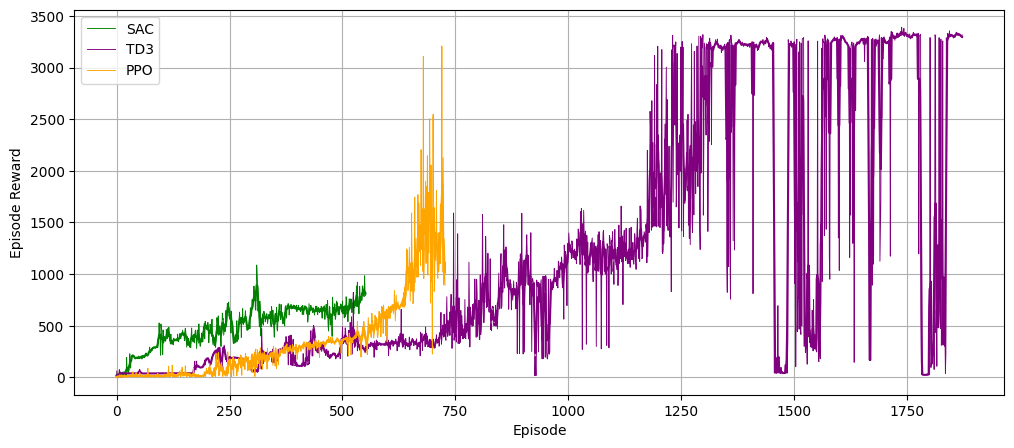

In [31]:
import json

filename = "models_rewards_2025-12-04 23:52:51.430453.json"  # <-- put your actual saved name here

with open(filename, 'r') as infile:
    models_rewards = json.load(infile)



window_size = 5
colors = ['green', 'purple', 'orange', 'red']
plt.figure(figsize=(12,5))


for i, item in enumerate(models_rewards.items()):
    k, v = item
    rewards = v
    # rewards = v[:500 + window_size]
    print(f'{k}: {len(rewards)}')
    plt.plot(rewards[:-window_size],
             label=k,
             linewidth=0.65,
             color=colors[i]
             )
    plt.plot(
        np.convolve(rewards,
                    np.ones(window_size)/window_size,
                    mode='same'
                    )[:-window_size],
        linewidth=1.5,
        # label=str(temperature) + '_mean',
        color=colors[i]
        )
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("")
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('output_whole.png')